### 定义数据集和数据加载器

In [104]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from dotenv import load_dotenv

load_dotenv()
output_folder_path = './output/football/'
os.makedirs(output_folder_path ,exist_ok=True)


class CustomSegmentationDataset(Dataset):
    
    def __init__(self, root, transformations = None):

        self.im_paths = sorted(glob(f"{root}/images/*.jpg"))
        self.gt_paths = [im_path for im_path in sorted(glob(f"{root}/images/*.png")) if "fuse" in im_path]
        self.transformations = transformations
        self.n_cls = 11
        
        assert len(self.im_paths) == len(self.gt_paths)
        
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im, gt = self.get_im_gt(self.im_paths[idx], self.gt_paths[idx])
        
        if self.transformations: im, gt = self.apply_transformations(im, gt)
        
        return im, gt
        
    def get_im_gt(self, im_path, gt_path): return self.read_im(im_path), self.read_im(gt_path)

    def read_im(self, path): return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]
    
def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05]):

    assert sum(split) == 1., "Sum of the split must be exactly 1"

    ds = CustomSegmentationDataset(root = root, transformations = transformations)
    n_cls = ds.n_cls

    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)

    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])

    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")

    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = 0)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = 0)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = 0)

    return tr_dl, val_dl, test_dl, n_cls
DATASET = os.getenv('FOOTBALL_DATASET')
folder_path= DATASET
root = folder_path
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), A.augmentations.transforms.Normalize(mean = mean, std = std), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 8)


There are 90 number of images in the train set
There are 5 number of images in the validation set
There are 5 number of images in the test set



### 一些可视化函数

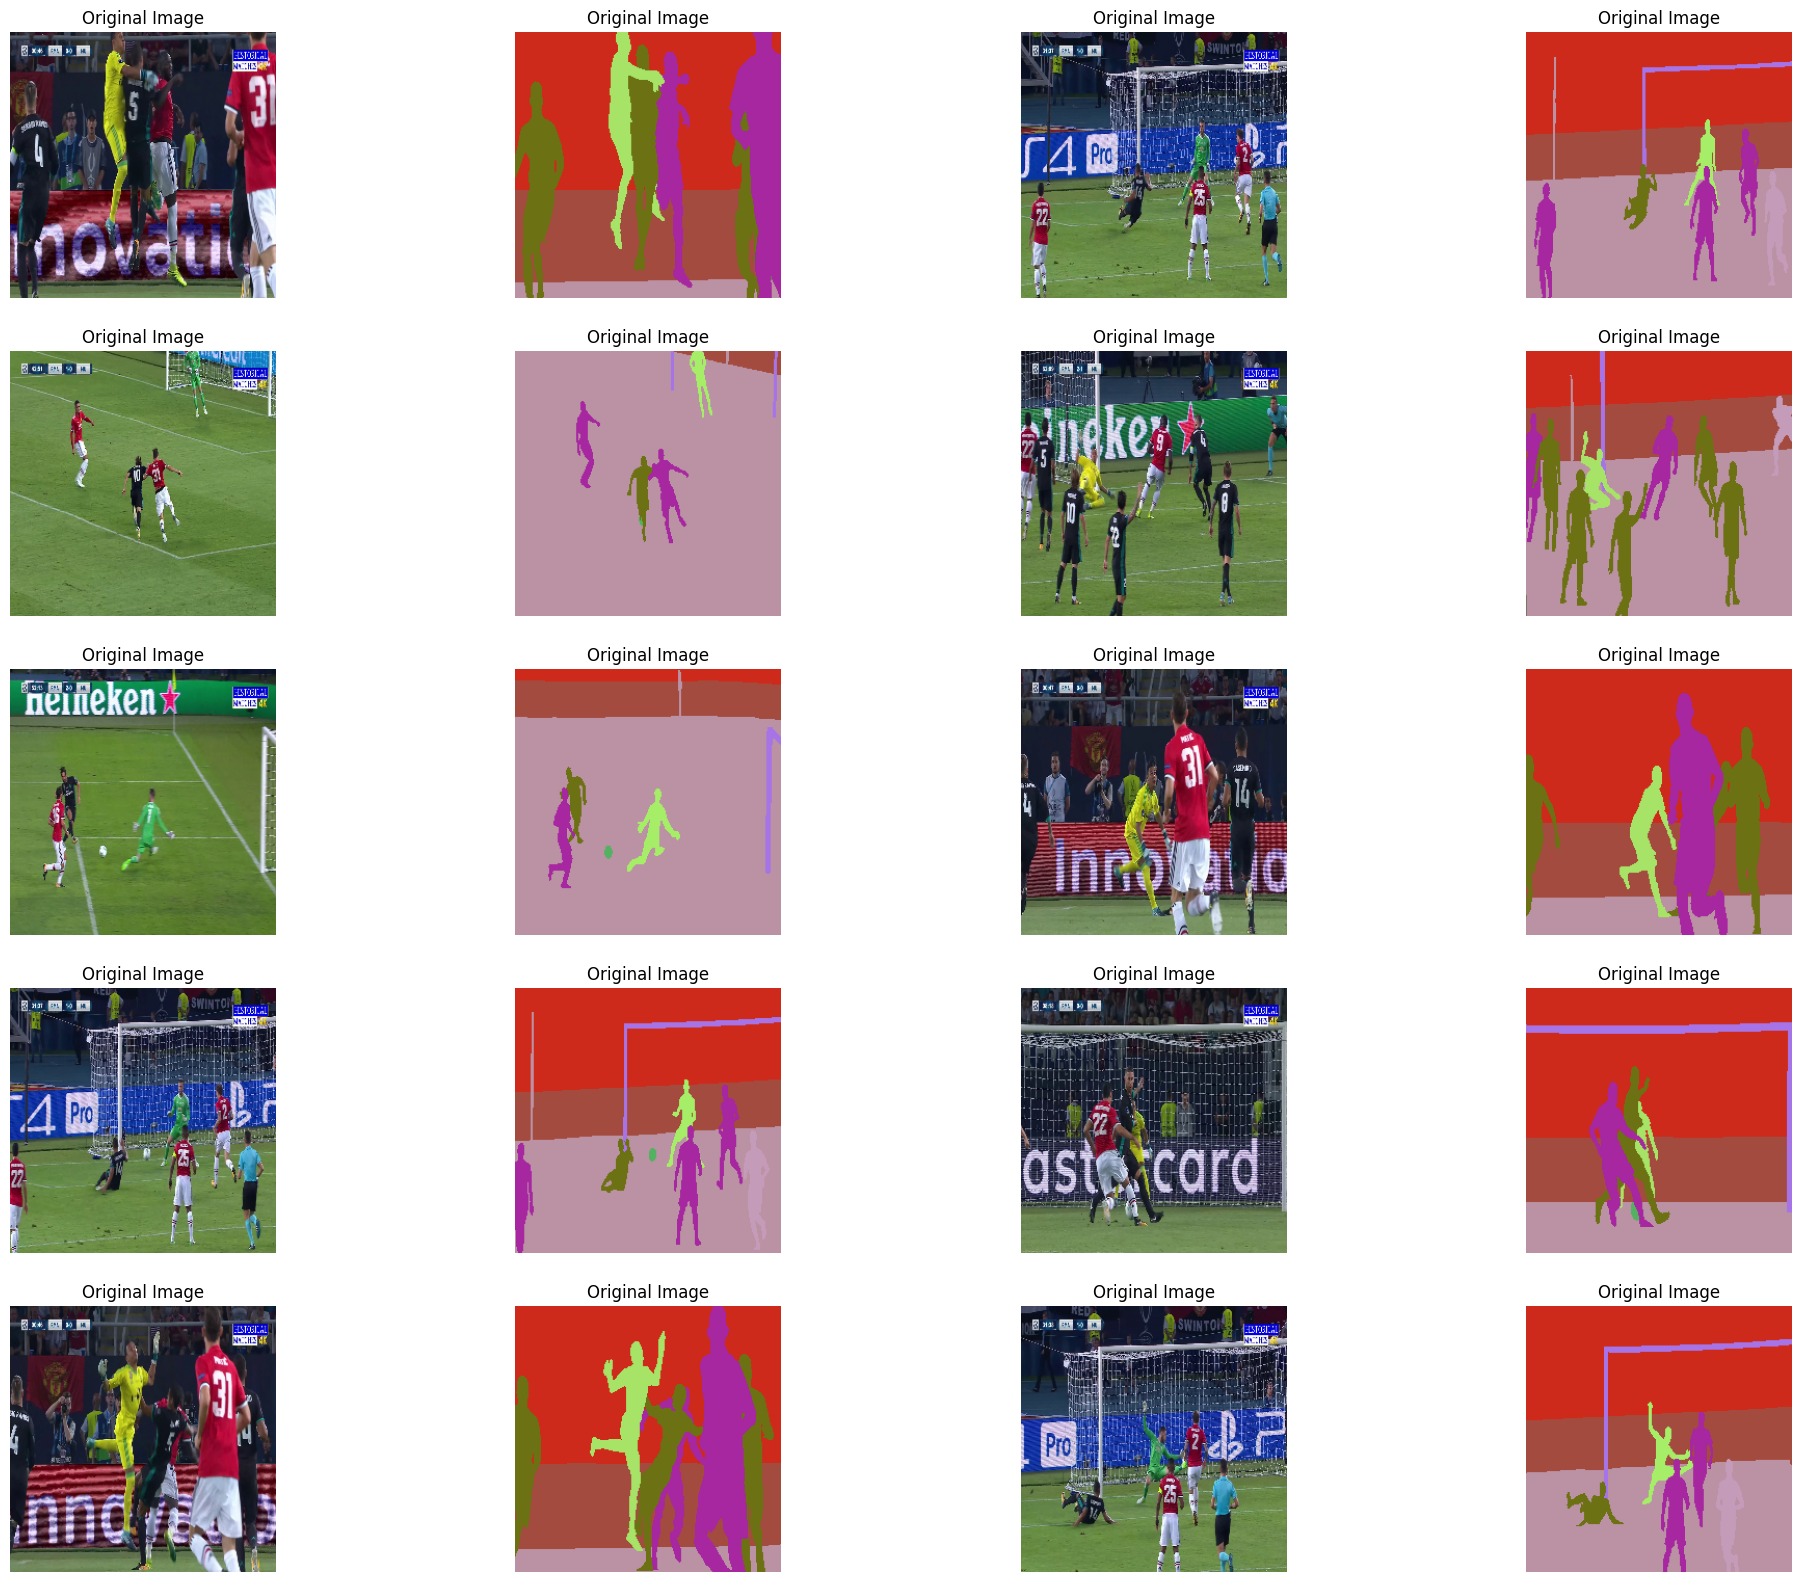

In [94]:
import random
from torchvision import transforms as tfs

def tn_2_np(t): 
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])
    
    rgb = True if len(t) == 3 else False
    
    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)
    
    return count + 1

def visualize(ds, n_ims):
    
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]
    
    for idx, index in enumerate(indices):
        
        if count == n_ims + 1: break
        im, gt = ds[index]
        
        # First Plot
        count = plot(rows, cols, count, im = im)
        
        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True)
        
visualize(tr_dl.dataset, n_ims = 20)

### 训练设置

In [95]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(classes = n_cls)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

In [96]:
import time
from tqdm import tqdm
from torch.nn import functional as F

class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):
        
        self.pred, self.gt = torch.argmax(F.softmax(pred, dim=1), dim = 1), gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred
        
    def to_contiguous(self, inp): return inp.contiguous().view(-1) 
    
    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()
        
        return float(match.sum()) / float(match.numel())

    def mIoU(self):
        
        with torch.no_grad():
            self.gt = torch.argmax(self.gt, dim = 1)
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)
                    
                else:
                    
                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
    
    def loss(self): return self.loss_fn(self.pred_, torch.argmax(self.gt, dim = 1))

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

### 训练并评估

In [97]:
MODELS_FOLDER = os.getenv('MODEL_FOLDER_PATH')
model_folder_path= MODELS_FOLDER
OUR_FOOTBALL_MODEL_File = os.path.join(model_folder_path+'football_best_model.pth')
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs):
    
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 10

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")
    
    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        
        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)
            
            preds = model(ims)
            
            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()
            
            tr_iou_ += met.mIoU()
            
            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()
            
            loss_.backward()
            opt.step()
            opt.zero_grad()
        
        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                

        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)
        
        if best_loss > (val_loss_):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, OUR_FOOTBALL_MODEL_File)

        if val_loss_ > best_loss:

            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
            
    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")
    
    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 15,)

Start training process...
Epoch 1 train process is started...


100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


Epoch 1 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 16.577 secs
Train Loss         -> 1.535
Train PA           -> 0.675
Train IoU          -> 0.608
Validation Loss    -> 2.136
Validation PA      -> 0.771
Validation IoU     -> 0.647

Loss decreased from inf to 2.136!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 12/12 [00:16<00:00,  1.40s/it]


Epoch 2 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 17.429 secs
Train Loss         -> 0.718
Train PA           -> 0.882
Train IoU          -> 0.788
Validation Loss    -> 1.182
Validation PA      -> 0.857
Validation IoU     -> 0.746

Loss decreased from 2.136 to 1.182!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 12/12 [00:26<00:00,  2.23s/it]


Epoch 3 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 27.321 secs
Train Loss         -> 0.430
Train PA           -> 0.917
Train IoU          -> 0.842
Validation Loss    -> 0.612
Validation PA      -> 0.891
Validation IoU     -> 0.798

Loss decreased from 1.182 to 0.612!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 12/12 [00:26<00:00,  2.19s/it]


Epoch 4 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 26.839 secs
Train Loss         -> 0.314
Train PA           -> 0.932
Train IoU          -> 0.868
Validation Loss    -> 0.373
Validation PA      -> 0.901
Validation IoU     -> 0.814

Loss decreased from 0.612 to 0.373!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 12/12 [00:22<00:00,  1.86s/it]


Epoch 5 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 22.727 secs
Train Loss         -> 0.254
Train PA           -> 0.940
Train IoU          -> 0.882
Validation Loss    -> 0.317
Validation PA      -> 0.904
Validation IoU     -> 0.819

Loss decreased from 0.373 to 0.317!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|██████████| 12/12 [00:19<00:00,  1.65s/it]


Epoch 6 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 20.227 secs
Train Loss         -> 0.215
Train PA           -> 0.947
Train IoU          -> 0.894
Validation Loss    -> 0.239
Validation PA      -> 0.925
Validation IoU     -> 0.854

Loss decreased from 0.317 to 0.239!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


Epoch 7 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 16.525 secs
Train Loss         -> 0.192
Train PA           -> 0.950
Train IoU          -> 0.898
Validation Loss    -> 0.212
Validation PA      -> 0.934
Validation IoU     -> 0.868

Loss decreased from 0.239 to 0.212!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process is started...


100%|██████████| 12/12 [00:16<00:00,  1.33s/it]


Epoch 8 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch 8 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process results: 

Train Time         -> 16.423 secs
Train Loss         -> 0.173
Train PA           -> 0.955
Train IoU          -> 0.910
Validation Loss    -> 0.228
Validation PA      -> 0.927
Validation IoU     -> 0.860

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process is started...


100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Epoch 9 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Epoch 9 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process results: 

Train Time         -> 16.165 secs
Train Loss         -> 0.159
Train PA           -> 0.959
Train IoU          -> 0.913
Validation Loss    -> 0.192
Validation PA      -> 0.937
Validation IoU     -> 0.876

Loss decreased from 0.228 to 0.192!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process is started...


100%|██████████| 12/12 [00:15<00:00,  1.33s/it]


Epoch 10 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Epoch 10 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process results: 

Train Time         -> 16.387 secs
Train Loss         -> 0.133
Train PA           -> 0.962
Train IoU          -> 0.924
Validation Loss    -> 0.155
Validation PA      -> 0.945
Validation IoU     -> 0.890

Loss decreased from 0.192 to 0.155!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process is started...


100%|██████████| 12/12 [00:15<00:00,  1.31s/it]


Epoch 11 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Epoch 11 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process results: 

Train Time         -> 16.141 secs
Train Loss         -> 0.126
Train PA           -> 0.966
Train IoU          -> 0.930
Validation Loss    -> 0.149
Validation PA      -> 0.948
Validation IoU     -> 0.896

Loss decreased from 0.155 to 0.149!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process is started...


100%|██████████| 12/12 [00:15<00:00,  1.32s/it]


Epoch 12 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch 12 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process results: 

Train Time         -> 16.297 secs
Train Loss         -> 0.131
Train PA           -> 0.960
Train IoU          -> 0.923
Validation Loss    -> 0.152
Validation PA      -> 0.945
Validation IoU     -> 0.889

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process is started...


100%|██████████| 12/12 [00:15<00:00,  1.32s/it]


Epoch 13 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Epoch 13 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process results: 

Train Time         -> 16.303 secs
Train Loss         -> 0.192
Train PA           -> 0.948
Train IoU          -> 0.903
Validation Loss    -> 0.405
Validation PA      -> 0.894
Validation IoU     -> 0.789

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process is started...


100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


Epoch 14 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch 14 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process results: 

Train Time         -> 16.033 secs
Train Loss         -> 0.172
Train PA           -> 0.947
Train IoU          -> 0.896
Validation Loss    -> 0.391
Validation PA      -> 0.899
Validation IoU     -> 0.812

Loss decreased from 0.405 to 0.391!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process is started...


100%|██████████| 12/12 [00:15<00:00,  1.30s/it]


Epoch 15 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

Epoch 15 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process results: 

Train Time         -> 16.001 secs
Train Loss         -> 0.121
Train PA           -> 0.962
Train IoU          -> 0.924
Validation Loss    -> 0.215
Validation PA      -> 0.930
Validation IoU     -> 0.865

Loss decreased from 0.391 to 0.215!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Train process is completed in 4.632 minutes.


### 学习曲线

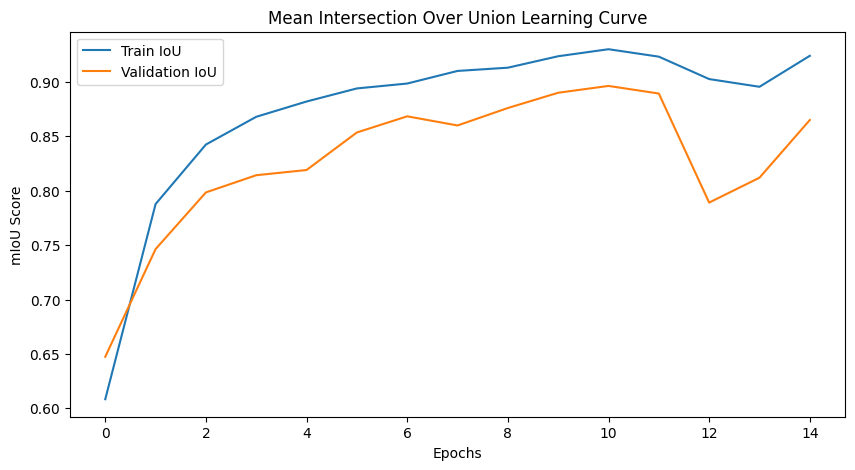

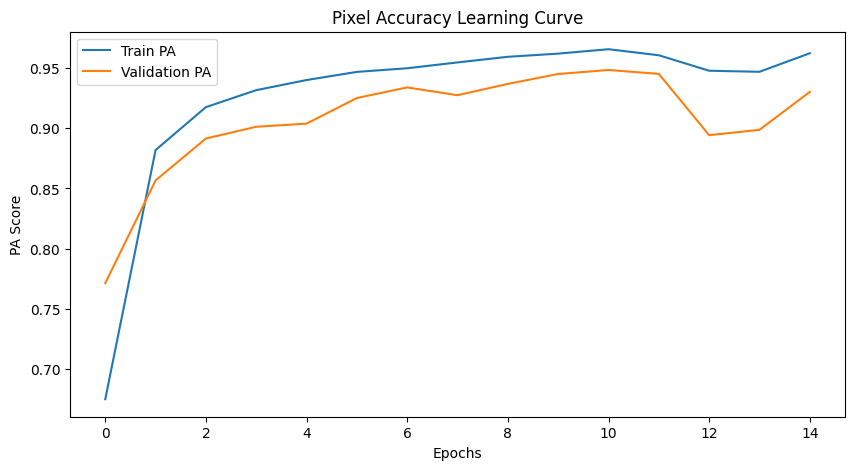

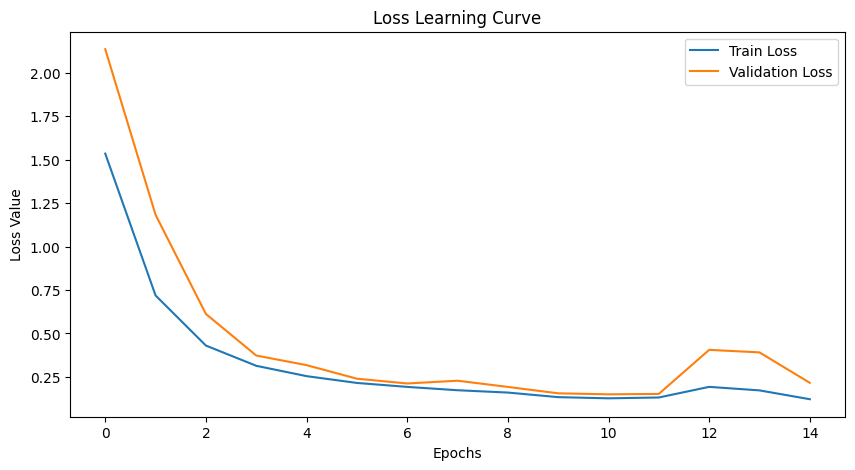

In [105]:
class Plot:
    
    def __init__(self, res):
        self.res = res
        
        self.visualize(metric1="tr_iou", metric2="val_iou", label1="Train IoU", 
                       label2="Validation IoU", title="Mean Intersection Over Union Learning Curve", 
                       ylabel="mIoU Score", filename=f"{output_folder_path}iou_learning_curve.png")
    
        self.visualize(metric1="tr_pa", metric2="val_pa", label1="Train PA", 
                       label2="Validation PA", title="Pixel Accuracy Learning Curve", 
                       ylabel="PA Score", filename=f"{output_folder_path}pa_learning_curve.png")
        
        self.visualize(metric1="tr_loss", metric2="val_loss", label1="Train Loss", 
                       label2="Validation Loss", title="Loss Learning Curve", 
                       ylabel="Loss Value", filename=f"{output_folder_path}loss_learning_curve.png")
        
    def plot(self, metric, label):
        plt.plot(self.res[metric], label=label)
    
    def decorate(self, ylabel, title, filename):
        plt.title(title)
        plt.xlabel("Epochs")
        plt.ylabel(ylabel)
        plt.legend()
        plt.savefig(filename)  # Save the plot
        plt.show()
    
    def visualize(self, metric1, metric2, label1, label2, title, ylabel, filename):
        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1)
        self.plot(metric2, label2)
        self.decorate(ylabel, title, filename)              
        
Plot(history)

### 测试

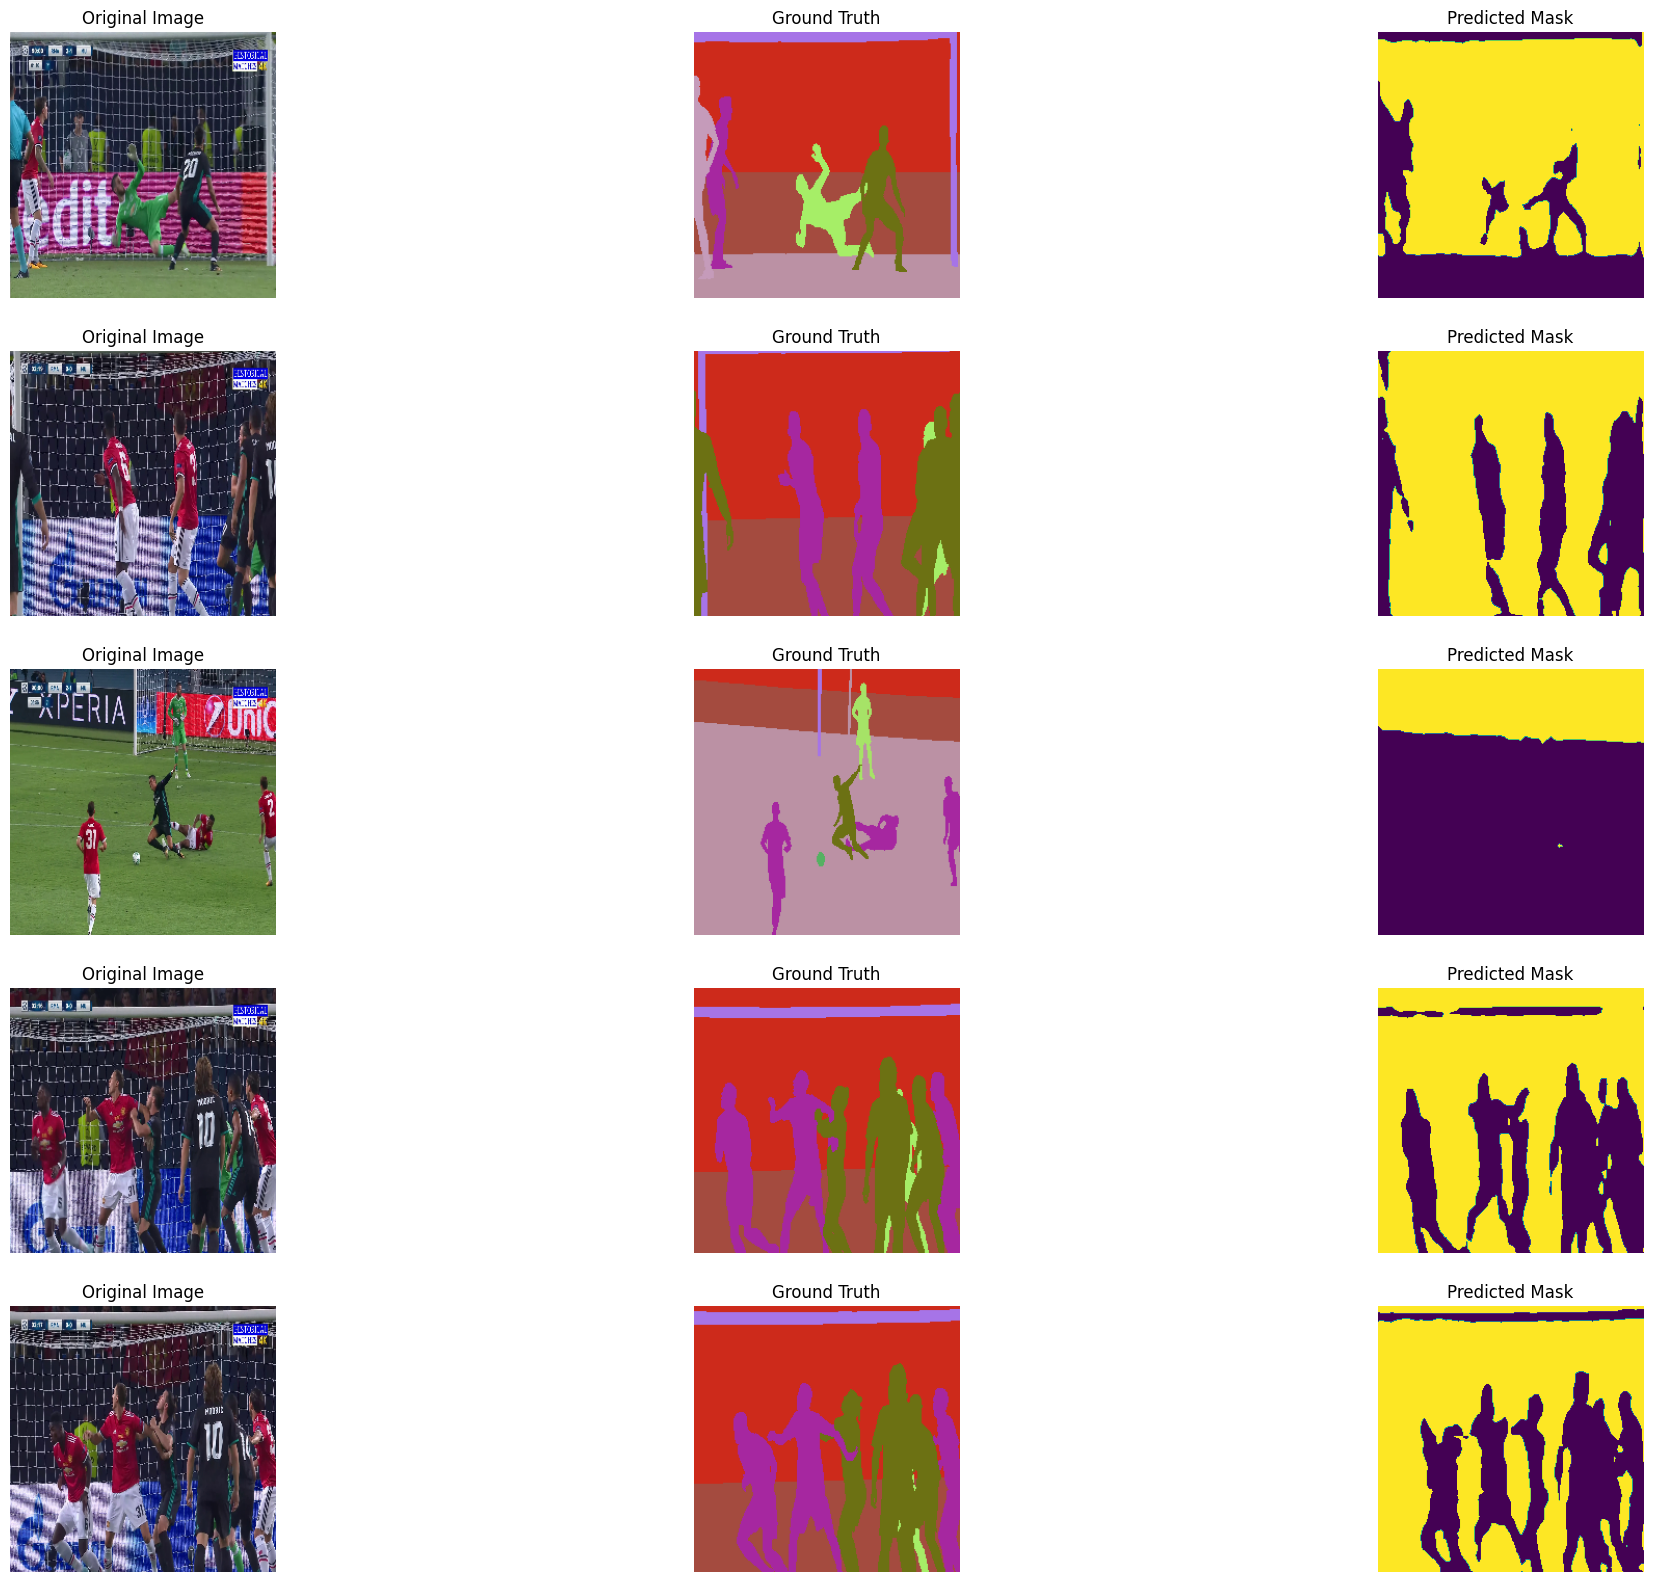

In [106]:
def inference(dl, model, device, n_ims = 15):
    
    cols = n_ims // 3; rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)
        
    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        
        # First plot
        count = plot(cols, rows, count, im)

        # Second plot
        count = plot(cols, rows, count, im = gt, gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")

        model = torch.load(OUR_FOOTBALL_MODEL_File)
    plt.savefig(f"{output_folder_path}OUTPUT_IMAGE")
inference(test_dl, model = model, device = device)